# Spatial domains

```{dropdown} <i class="fas fa-brain"></i>&nbsp;&nbsp;&nbsp;Key takeaways

:::{card}
:link: spatial-domains-key-takeaway-1
:link-type: ref
Spatial domains are clusters that both reflecting similarity of spots or cells in terms of gene expression as well as spatial proximity.
:::

:::{card}
:link: spatial-domains-key-takeaway-2
:link-type: ref
Methods for identifying spatial domains can also incorporate the histological information available through spatial omics technologies.
:::
:::{card}
:link: spatial-domains-key-takeaway-3
:link-type: ref
We presented how to identify spatial domains in Squidpy by combining the nearest neighbor graph and the spatial proximity graph, as well as the usage of SpaGCN.
:::

```


``````{dropdown} <i class="fa-solid fa-gear"></i>&nbsp;&nbsp;&nbsp;Environment setup
`````{tab-set}
   
````{tab-item} Steps
```{include} ../_static/default_text_env_setup.md
```
````

````{tab-item} yml
```{literalinclude} spatial.yml
:language: yaml
```
````

`````
``````

*TL;DR we provide an overview of spatial data analysis methods for the analysis of spatial omics data*

(spatial-domains-key-takeaway-1)=
## Motivation

When analyzing spatial omics dataset, we might be interested in identifying *spatial patterns* in the data, that is, identifying features that vary in *space*. Spatial omics data entails not only the usual cell x gene matrix but, additionally orthogonal information that we can use to describe and predict features of interest from the data, such as the tissue image and the spatial coordinates. 

The identification of cell types or states is one of the first data analysis tasks, as it allows to formulate key hypotheses from the data. This is usually performed by clustering the data based on some type of similarity between data points in feature space. One of the most popular approaches for this task is to compute a nearest neighbor graph on a (low dimensional) representation of the data and then perform community detection on such a graph. In the case of spatial omics data, such an approach can be easily extended to account for the similarity in coordinate space (and not only feature space) of the data. We can call this task "identification of spatial domains" since it includes both gene and spatial similarity for cluster identification. 

Different models have been developed for identifying spatial domains with varying underlying concepts. They can generally be divided into two groups of methods. The first models spatial dependencies of gene expression and the second additionally incorporates information extracted from histological images. 


:::{figure-md} domains

<img src="../_static/images/spatial/domains.jpeg" alt="Spatial domains overview" class="bg-primary mb-1" width="800px">

Spatial domains are clusters that both account for similarities in gene expression as well as spatial proximity. Methods can additionally incorporate the histological image information.
:::

Examples for the first group are:
* Spatial domains in Squidpy  {cite}`Palla2022`
* Hidden-Markov random field (HMRF) {cite}`Dries2021`
* BayesSpace {cite}`Zhao2021-vi`

Examples for the second group are:
* spaGCN {cite}`Hu2021-SpaGCN`
* stLearn {cite}`pham_stlearn_2020`

In this notebook, we will show how to calculate spatial domains in Squidpy and how to apply spaGCN.



## Environment setup and data

We first load the packages needed in this tutorial and the dataset. 

In [1]:
import scanpy as sc
import squidpy as sq

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor="white")

The dataset used in this tutorial consists of 1 tissue slides from 1 mouse and is provided by [10x Genomics Space Ranger 1.1.0](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.1.0/V1_Adult_Mouse_Brain). The dataset was pre-processed in Squidpy, which provides a loading function for this dataset. We shortly inspect the returned AnnData object. 

In [2]:
adata = sq.datasets.visium_hne_adata()
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

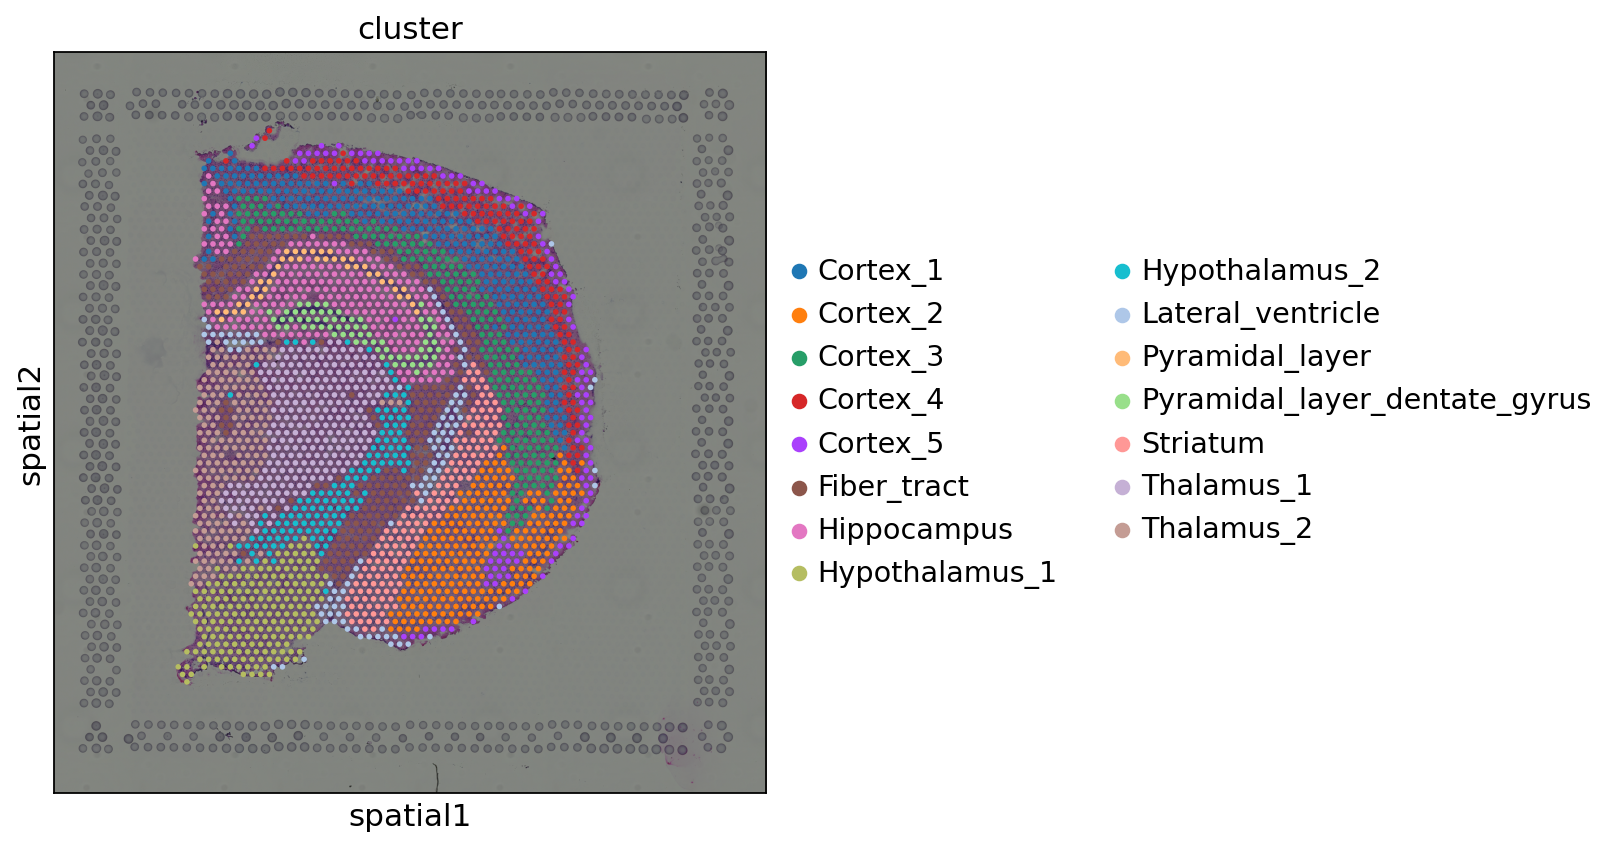

In [3]:
sq.pl.spatial_scatter(adata, color="cluster", figsize=(10, 10))

(spatial-domains-key-takeaway-3)=
## Spatial domains in Squidpy
In this section, we will illustrate this approach with a pedagogical example using Squidpy, and then point to a more advanced algorithm to accomplish this task. 

Let's work with the Visium dataset for the purpose of this example. In this case, we will be using the term "spot" referring to observations stored in the rows of the AnnData object.
First off, we want an algorithm that encodes similarity between observations in some coordinate space, such as gene expression space and spatial coordinates. A nearest neighbor graph is a reliable representation for this task. Let's compute the nearest neighbor graph in spatial coordinates and the nearest neighbor graph in PCA coordinates. As we can see based on `adata.obsm['X_pca']` the PCA was already performed on the dataset, hence we can directly compute the KNN graph.

In [4]:
# nearest neighbor graph
sc.pp.neighbors(adata)
nn_graph_genes = adata.obsp["connectivities"]
# spatial proximity graph
sq.gr.spatial_neighbors(adata)
nn_graph_space = adata.obsp["spatial_connectivities"]

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
Creating graph using `grid` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)


Second, we want to identify communities (clusters) in both representations jointly. One straightforward way to do this is by simply adding the two graphs and compute leiden on the joint graph. We can also weight the importance of each graph based on an hyperparameters `alpha`.

In [5]:
alpha = 0.2

joint_graph = (1 - alpha) * nn_graph_genes + alpha * nn_graph_space
sc.tl.leiden(adata, adjacency=joint_graph, key_added="squidpy_domains")

running Leiden clustering
    finished: found 17 clusters and added
    'squidpy_domains', the cluster labels (adata.obs, categorical) (0:00:00)


Let's visualize the results with Squidpy. The first annotation (`cluster`) is a cluster annotation based only on gene expression similarity.

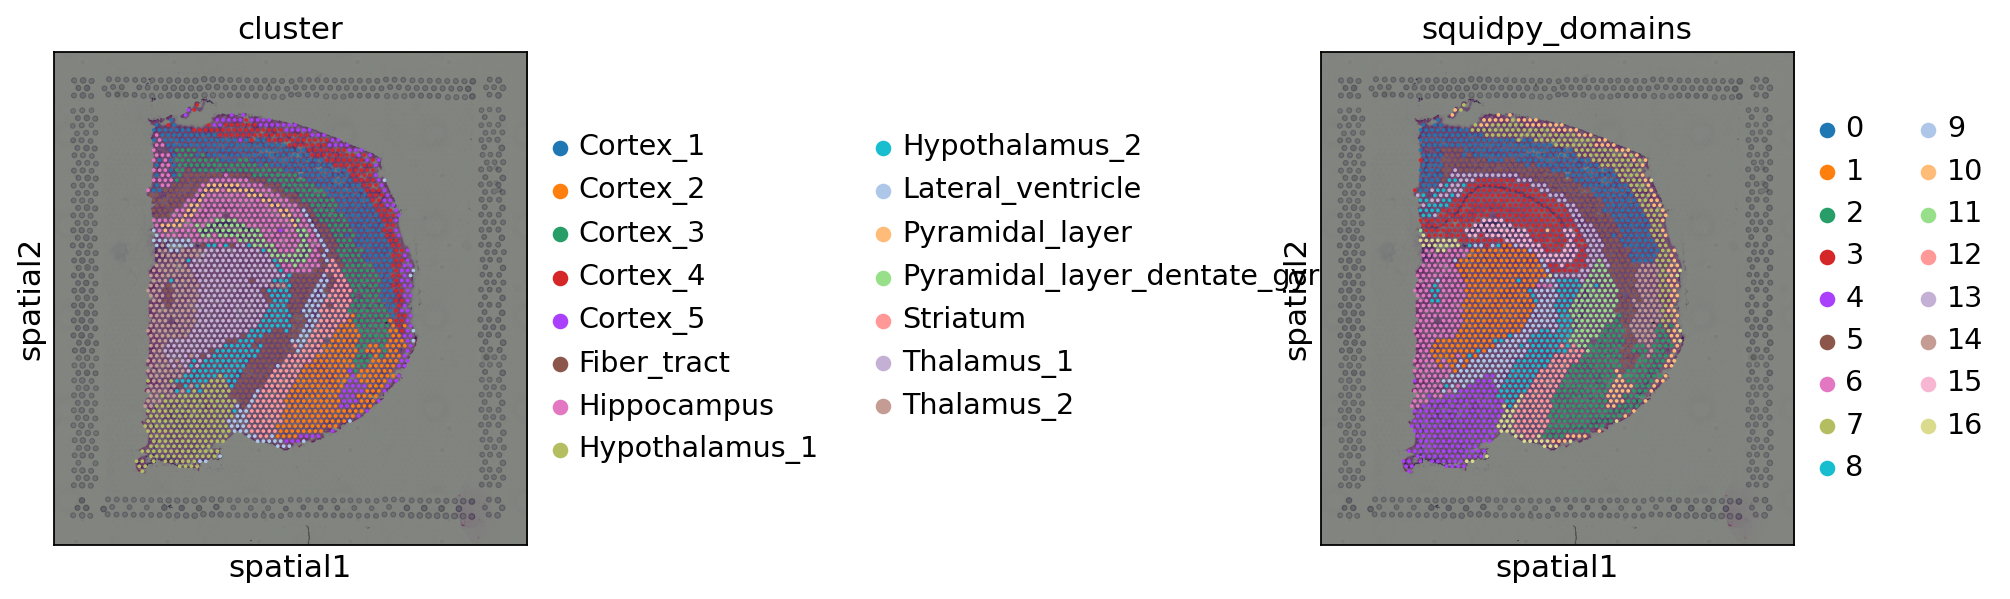

In [6]:
sq.pl.spatial_scatter(adata, color=["cluster", "squidpy_domains"], wspace=0.9)

We can see that such an approach is essentially "smoothing" the cluster annotations based on spatial distances. Despite it being a purely pedagogical approach, it has been used in practice {cite}`Chen2022-oa`. We invite the reader to check out more principled approaches.

(spatial-domains-key-takeaway-2)=
## SpaGCN

The second approach we are showing in this tutorial is SpaGCN {cite}`Hu2021-SpaGCN`. SpaGCN is a graph convolutional network approach that leverages gene expression, spatial location and histology in spatial omics data analysis. SpaGCN combines gene expression, spatial information and the histological images in an undirected weighted graph. This graph represents the overall spatial dependencies present in the data, which can be used in a graph convolutional approach to identify spatial domains. 


We are now showing how to use SpaGCN in practice. We first load the respective additional packages:


In [7]:
import numpy as np
import requests
import SpaGCN as spg
from PIL import Image

As already mentioned, SpaGCN takes as additional input the histological image of the spatial dataset. For this purpose, we additionally load the high-resolution tif from the 10X Genomics website into our notebook. SpaGCN can also be used without histology information. We will refer to it at a later point. 

In [8]:
img = np.asarray(
    Image.open(
        requests.get(
            "https://cf.10xgenomics.com/samples/spatial-exp/1.1.0/V1_Adult_Mouse_Brain/V1_Adult_Mouse_Brain_image.tif",
            stream=True,
        ).raw
    )
)

/home/icb/anna.schaar/miniconda3/envs/spatial-book/lib/python3.9/site-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (132748287 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


The spatial AnnData object in this tutorial was already processed. To ensure we are applying the correct data processing needed for SpaGCN, we are resetting `adata.X` to the raw counts.

In [9]:
# requires raw data in X
adata.X = adata.raw.X

### Integrate gene expression and histology into a Graph

SpaGCN requires passing the spatial array coordinates as well as the pixel coordinates to the model. The array coordinates are typically stored in `adata.obs["array_row"]` and `adata.obs["array_col"]`. The pixel coordinates are stored in `adata.obsm["spatial"]`.

In [10]:
# Set coordinates
x_array = adata.obs["array_row"].tolist()
y_array = adata.obs["array_col"].tolist()
x_pixel = (adata.obsm["spatial"][:, 0]).tolist()
y_pixel = adata.obsm["spatial"][:, 1].tolist()

First SpaGCN aggregates the gene expression and histology information into a joint graph in the form of an adjacency matrix. Two spots are considered connected if they are physically close and they have similar histological features extracted from the image. The respective function requires the user to pass the x and y pixel spaces, the image and additionally two parameters: `beta` and `alpha`.

* `beta` determines the area of each spot when extracting the color intensity. This value can typically be obtained from `adata.uns['spatial']`. Typically, Visium spots have a size of 55 to 100 $\mu m$.

* `alpha` determines the weight given to the histology image when calculating the Euclidean distance between spots. `alpha=1` means the histology pixel intensity value has the same scale variance as the (x,y) coordinate.


In [11]:
# Calculate adjacent matrix
adj = spg.calculate_adj_matrix(
    x=x_pixel,
    y=y_pixel,
    x_pixel=x_pixel,
    y_pixel=y_pixel,
    image=img,
    beta=55,
    alpha=1,
    histology=True,
)

Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  96.93674686223055 519.0133178897761 37.20274924909862
Var of x,y,z =  2928460.011122931 4665090.578837907 4665090.578837907


### Preprocessing of gene expression data

Next, we perform a basic preprocessing strategy on the gene expression data by filtering genes that are expressed in fewer than three spots. Additionally, the counts are normalized and log transformed.

In [12]:
adata.var_names_make_unique()

sc.pp.filter_genes(adata, min_cells=3)

# find mitochondrial (MT) genes
adata.var["MT_gene"] = [gene.startswith("MT-") for gene in adata.var_names]
# remove MT genes (keeping their counts in the object)
adata.obsm["MT"] = adata[:, adata.var["MT_gene"].values].X.toarray()
adata = adata[:, ~adata.var["MT_gene"].values].copy()

# Normalize and take log for UMI
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


### Hyperparameters of SpaGCN
As a first step, SpaGCN finds the characteristic length scale $l$. This parameter determines how rapidly the weight decays as a function of distance. To find $l$, one first has to specify the parameter $p$ which describes the percentage of total expression contributed by neighborhoods. For Visium data, SpaGCN recommends `p=0.5`. For data with smaller capture areas like Slide-seq V2 or MERFISH, it is recommended to choose a higher contribution value.


In [13]:
p = 0.5
# Find the l value given p
l = spg.search_l(p, adj)

Run 1: l [0.01, 1000], p [0.0, 176.04695830342547]
Run 2: l [0.01, 500.005], p [0.0, 38.50406265258789]
Run 3: l [0.01, 250.0075], p [0.0, 7.22906494140625]
Run 4: l [0.01, 125.00874999999999], p [0.0, 1.119886875152588]
Run 5: l [62.509375, 125.00874999999999], p [0.07394278049468994, 1.119886875152588]
Run 6: l [93.7590625, 125.00874999999999], p [0.4443991184234619, 1.119886875152588]
Run 7: l [93.7590625, 109.38390625], p [0.4443991184234619, 0.7433689832687378]
Run 8: l [93.7590625, 101.571484375], p [0.4443991184234619, 0.5843360424041748]
Run 9: l [93.7590625, 97.66527343749999], p [0.4443991184234619, 0.5119975805282593]
Run 10: l [95.71216796875, 97.66527343749999], p [0.47760796546936035, 0.5119975805282593]
recommended l =  96.688720703125


If the number of spatial domains in the tissue is known, SpaGCN can calculate a suitable resolution to generate the respective number. This might be for example the case in brain samples, where one wants to find a certain number of cortex layers in the spatial slide. If the number of domains is not known, SpaGCN varies the resolution parameter from 0.2 to 0.1 and uses a resolution that results in the highest Silhouette score.

We will specify the number of clusters to the number of cell types present in our example dataset and set `n_clusters=15`. 


In [14]:
# Search for suitable resolution
res = spg.search_res(adata, adj, l, target_num=15)

Start at res =  0.4 step =  0.1
Initializing cluster centers with louvain, resolution =  0.4
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
Epoch  0
Res =  0.4 Num of clusters =  10
Initializing cluster centers with louvain, resolution =  0.5
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain', the cluster labels (adata.obs, cat

We have now computed all required parameters and can initialize SpaGCN and set the $l$ hyperparameter. 

In [15]:
model = spg.SpaGCN()
model.set_l(l)

Next, we train the model with the suited resolution to identify 15 spatial domains.

In [16]:
model.train(adata, adj, res=res)

Initializing cluster centers with louvain, resolution =  0.65
computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
Epoch  70
delta_label  0.000744047619047619 < tol  0.001
Reach tolerance threshold. Stopping training.
Total epoch: 79


We now predict the respective spatial domain for each cell in the dataset. Additionally, the model returns the probability of each cell belonging to one of the domains. We will not leverage this information in this tutorial.

In [17]:
y_pred, prob = model.predict()

We are saving the spatial domains now into `adata.obs` and save it as a categorical for convenient plotting.

In [18]:
adata.obs["spaGCN_domains"] = y_pred
adata.obs["spaGCN_domains"] = adata.obs["spaGCN_domains"].astype("category")

Let us inspect the result in a spatial scatter plot and compare it to the original annotations in the dataset.

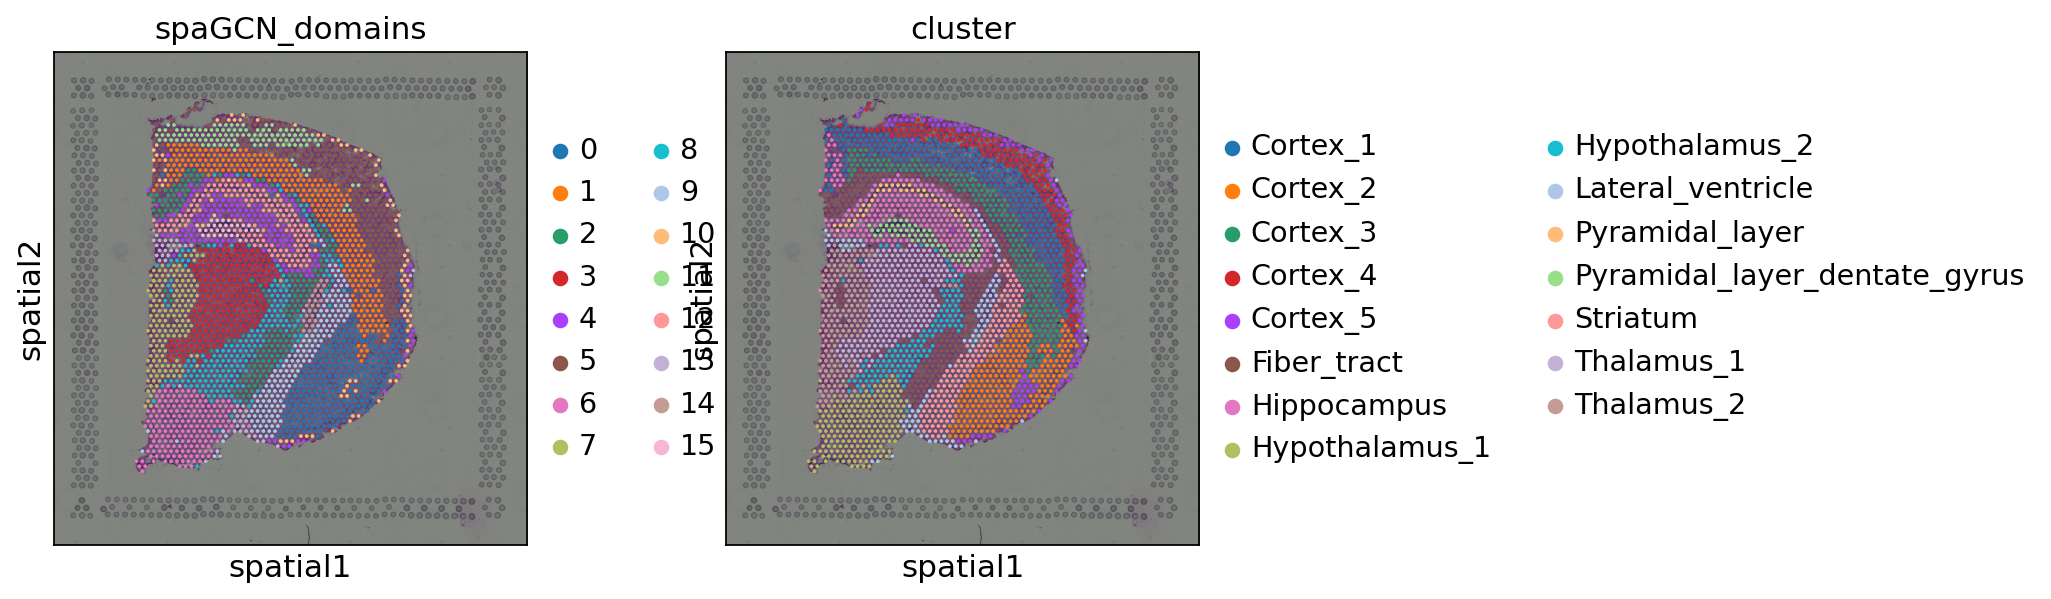

In [19]:
sq.pl.spatial_scatter(adata, color=["spaGCN_domains", "cluster"])

As we can see, the method quite accurately identified spatial domains. Interestingly, these domains correspond quite well to the original annotation. However, we can observe a few outliers as some spots are still spread across the dataset and are not assigned to the same domain. SpaGCN provides a function to refine the spatial domains, which we will show now.

### Refining the detected spatial domains

SpaGCN includes an optional refinement step to enhance the clustering result which inspects the domain assignment of each spot and its neighboring spots. In cases where more than half of the neighboring spots have been assigned to a different domain, the spot will be relabeled to the main domain of its neighboring spots. The refinement step will only impact a few spots. Generally, SpaGCN only recommends the refinement when the dataset is expected to have clear domain boundaries.

For the refinement, SpaGCN first calculated an adjacency matrix without accounting for the histological image.


In [20]:
adj_2d = spg.calculate_adj_matrix(x=x_array, y=y_array, histology=False)

Calculateing adj matrix using xy only...


This adjacency matrix is now used in the refinement together with the previously computed domains.

In [21]:
refined_pred = spg.refine(
    sample_id=adata.obs.index.tolist(),
    pred=adata.obs["spaGCN_domains"].tolist(),
    dis=adj_2d,
)

We are saving the refined spatial domains now into `adata.obs` and save it as a categorical for convenient plotting.

In [22]:
adata.obs["refined_spaGCN_domains"] = refined_pred
adata.obs["refined_spaGCN_domains"] = adata.obs["refined_spaGCN_domains"].astype(
    "category"
)

Let us inspect the refined spatial domains compared to the original spatial domains.

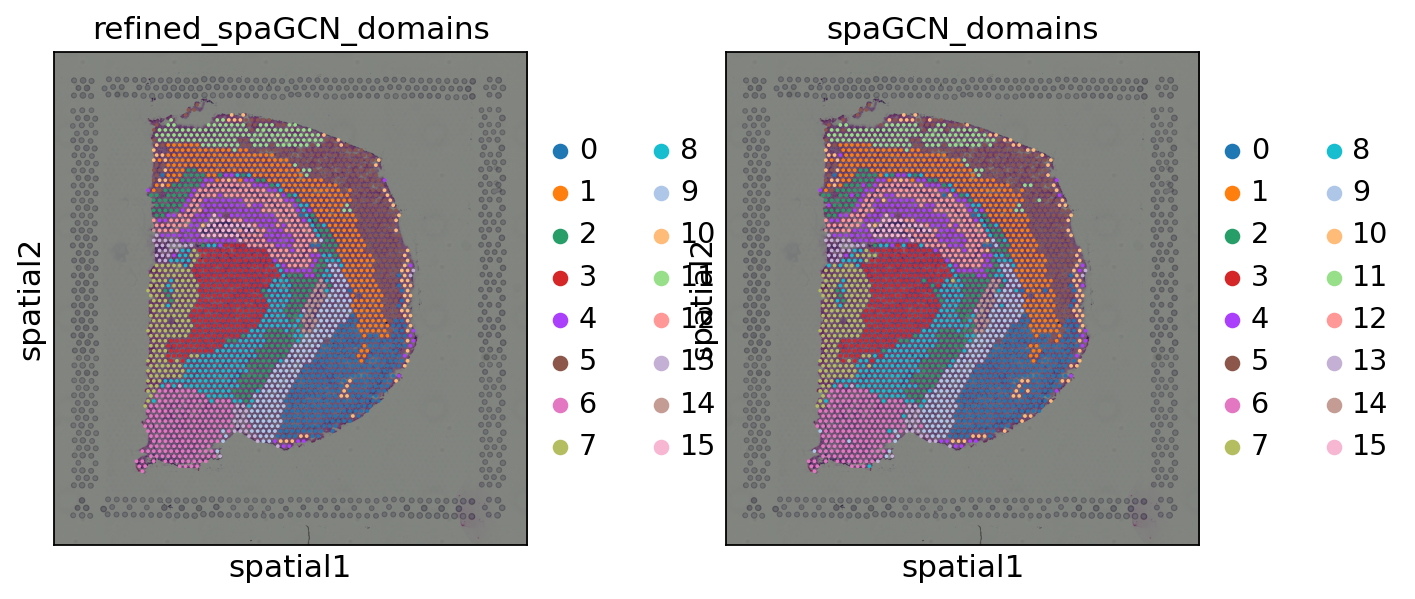

In [23]:
sq.pl.spatial_scatter(adata, color=["refined_spaGCN_domains", "spaGCN_domains"])

As we can see the refined spatial domains do not show outliers, but clear boundaries between the different domains. As a next step, one could now annotate the identified spatial domains or use them to calculate spatially variable genes. 

## References

```{bibliography}
:filter: docname in docnames
:labelprefix: spatial
```

## Contributors
### Authors
* Giovanni Palla
* Anna Schaar

### Reviewers
* Lukas Heumos